In [17]:
import pandas as pd
import numpy as np
import re
import contractions
from tqdm.notebook import tqdm
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("train.csv")
df.head()

In [18]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# df['TOXIC']=np.where(df[labels].sum(axis=1)>0,1,0)
# df['TOXIC'].value_counts()17988

### Data Preprocessing

In [ ]:
def preprocess(text):
    preprocessed_text = []
    for each_text in tqdm(text):
        text = contractions.fix(each_text)
        text = re.sub("\n", " ", text)
        text = re.sub("[\d+\W+]", " ", text)
        text = re.sub("\s+", " ", text)
        text = re.sub(r"<.*>", " ", text, flags=re.MULTILINE)
        text = re.sub(r"http\S+", " ", text, flags=re.MULTILINE)
        text = re.sub(r"www\S+", " ", text, flags=re.MULTILINE)
        text = re.sub(r"(\w)(\1{2,})", "\\1", text, flags=re.MULTILINE)
        text = re.sub(r"\b\w{1,2}\b", " ", text)
        preprocessed_text.append(text)
    return preprocessed_text

In [ ]:
processed_data = preprocess(df["comment_text"].values)
df_preprocessed = pd.DataFrame({"processed_comment": processed_data})
df["processed_comment"] = df_preprocessed

In [ ]:
for i in np.random.randint(0, len(df), size=5):
    print("----Original text-----", df["comment_text"].values[i])
    print("\n")
    print("----Processecd text-----", df["processed_comment"].values[i])
    print("\n")
    print("\n")

In [ ]:
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words("english")

In [ ]:
nltk.download("wordnet")
nltk.download("omw-1.4")

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

lemma = WordNetLemmatizer()
processed_text = [
    [
        lemma.lemmatize(each_wrd, pos="v")
        for each_wrd in text_to_word_sequence(each_sent)
        if each_wrd not in stopwords
    ]
    for each_sent in processed_data
]
processed_text[1:2]

In [ ]:
preprocessed_data = []
for i in processed_text:
    preprocessed_data.append(" ".join(i))
preprocessed_data[1:5]

In [ ]:
df_preprocessed = pd.DataFrame({"processed_comment": preprocessed_data})
df["processed_comment"] = df_preprocessed

In [ ]:
for i in np.random.randint(0, len(df), size=5):
    print(i)
    print("----Original text-----", df["comment_text"].values[i])
    print("\n")
    print("----Processecd text-----", df["processed_comment"].values[i])
    print("\n")
    print("\n")

In [ ]:
df.to_csv("Preprocessed train.csv")

### Logistic Regression Implementation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    decode_error="ignore", ngram_range=(1, 1), max_df=0.95, min_df=10
)
X = tfidf.fit_transform(df["processed_comment"].values).todense()

In [ ]:
y = df["TOXIC"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

In [ ]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
model_lg = lg.fit(X_train, y_train)
y_preds = model_lg.predict(X_test)
y_preds_prob = model_lg.predict_proba(X_test)[:, 1]

In [ ]:
y_preds_prob = model_lg.predict_proba(X_test)[:, 1]
y_preds_prob[1:20]

In [ ]:
y_preds

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_preds_prob)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

pred_matrix = confusion_matrix(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
pred_matrix

In [ ]:
precision

In [ ]:
recall

In [ ]:
f1

## Neural Network Implementation

In [19]:
from tensorflow.keras.layers import TextVectorization

In [20]:
dfpro = pd.read_csv("Preprocessed train.csv")
dfpro.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_comment
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edit make username hardcore metall...
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingly stick th...
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really try edit war guy constantly rem...
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,cannot make real suggestions improvement wonde...
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page


In [21]:
dfpro.fillna(" ", inplace=True)

<AxesSubplot:ylabel='Count'>

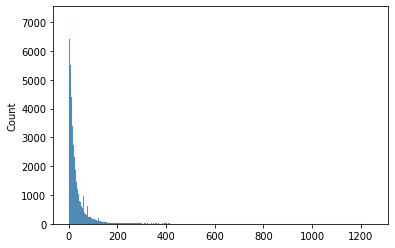

In [22]:
comment_len = [len(comment.split()) for comment in dfpro["processed_comment"]]
sns.histplot(comment_len)

In [23]:
max(comment_len)

1250

#### Vectorisation

In [24]:
X = dfpro["processed_comment"]
y = dfpro[labels].values

In [25]:
MAX_FEATURES = 200000

In [26]:
vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode="int"
)

In [27]:
vectorizer.adapt(X.values)

In [28]:
vectorizer_text = vectorizer(X.values)

In [29]:
vectorizer_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  521,     5,     9, ...,     0,     0,     0],
       [13075,   839,   404, ...,     0,     0,     0],
       [  287,   285,    72, ...,     0,     0,     0],
       ...,
       [23359,  5479,   559, ...,     0,     0,     0],
       [   36,    12,   133, ...,     0,     0,     0],
       [   72,    13,   114, ...,     0,     0,     0]])>

In [30]:
# creating pipeline for memory optimisation
# MCSHBAP - map, cache, shuffle, batch, prefetch from tensor_slices,list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorizer_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)  # prevents bottleneck

In [31]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [32]:
batch_x

array([[   105,      4,    248, ...,      0,      0,      0],
       [    27,     38, 109497, ...,      0,      0,      0],
       [    13,    268,     41, ...,      0,      0,      0],
       ...,
       [  1432,  12082,   1869, ...,      0,      0,      0],
       [    13,   4150,     62, ...,      0,      0,      0],
       [  2935,    590,   1547, ...,      0,      0,      0]])

In [33]:
## Train test split
train = dataset.take(int(len(dataset) * 0.7))
val = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

In [34]:
len(train)

6981

In [35]:
train_generator = train.as_numpy_iterator()

In [36]:
train_generator.next()

(array([[  3601,      6,      0, ...,      0,      0,      0],
        [ 52805,  10642,   1806, ...,      0,      0,      0],
        [    32,    132,    160, ...,      0,      0,      0],
        ...,
        [   128,    124,      3, ...,      0,      0,      0],
        [ 25028,   2762, 128217, ...,      0,      0,      0],
        [   270,   1102,     52, ...,      0,      0,      0]]),
 array([[0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

#### Model Building

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dropout,
    Bidirectional,
    Embedding,
    Dense,
    Flatten,
)

In [20]:
with tf.device("/GPU:0"):
    model = Sequential()
    # Create the embedding layer
    model.add(Embedding(MAX_FEATURES + 1, 300))
    # model.add(Flatten())
    # Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(300, activation="tanh")))
    # Feature extractor Fully connected layers
    model.add(Dense(128, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    # Final layer
    model.add(Dense(6, activation="sigmoid"))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         60000300  
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               76928     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [22]:
model.compile(loss="BinaryCrossentropy", optimizer="Adam")

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stp = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=4)
# saving the model with the best metric
mdl_save = ModelCheckpoint(
    "best_model02.h5", save_best_only=True, monitor="val_loss", mode="min"
)

In [1]:
history = model.fit(
    train, validation_data=val, epochs=25, callbacks=[early_stp, mdl_save]
)

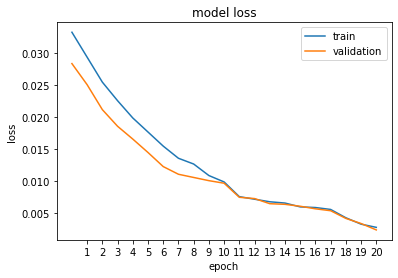

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.xticks(x, labels)
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [39]:
model = tf.keras.models.load_model("best_model.h5")

In [20]:
input_text = vectorizer("the weather is so good")
model.predict(np.array([input_text]))

1/1 [==============================] - 2s 2s/step


array([[0.54937404, 0.07808019, 0.15660417, 0.10183867, 0.26980236,
        0.5132418 ]], dtype=float32)

In [ ]:
batch_x, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_x) > 0.5).astype(int)

In [ ]:
batch_y

In [22]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import roc_auc_score, classification_report

In [23]:
pre = Precision()
re = Recall()
auc = AUC(curve="ROC", multi_label=True, num_labels=6)

In [5]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true, verbose=0)

    # Flatten the predictions
    # y_true = y_true.flatten()
    # yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    auc.update_state(y_true, yhat)

In [25]:
print(
    f"Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, AUC:{auc.result().numpy()}"
)

Precision: 0.9795976281166077, Recall:0.9732545018196106, AUC:0.9970322251319885


#### Deployment on Gradio app

In [2]:
!pip install gradio jinja2

In [42]:
import gradio as gr

In [43]:
labels = ["TOXIC", "SEVERE TOXIC", "OBSCENE", "THREAT", "INSULT", "IDENTITY HATE"]


def comment_toxicity(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    prediction_text = " "
    for idx, col in enumerate(labels):
        prediction_text += "{}: {}\n".format(col, results[0][idx] > 0.5)
    return prediction_text

In [3]:
interface = gr.Interface(
    fn=comment_toxicity,
    title="TOXIC COMMENT CLASSIFIER",
    inputs=gr.inputs.Textbox(lines=2, placeholder="Comment to score", label="COMMENT"),
    outputs=gr.outputs.Textbox("text", label="OUTPUT"),
    allow_flagging="manual",
    flagging_options=["Incorrect", "Partially Correct", "Correct"],
    flagging_dir="./Flagged data",
)

In [4]:
interface.launch(share=True, debug=True)